In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn 
import os
import matplotlib.pyplot as plt
import matplotlib
import cooltools
import cooler
from NGS import HiCTools as HT
import pyBigWig
from scipy.stats import mannwhitneyu
import matplotlib.colors as cl
from typing import Callable
import bbi
from typing import Tuple

# Define functions

In [2]:
def loadBwBins(fileP, binFrame):
    """Calculate average signal in bw-file inside
    the bins (start, end) specified in bins on the chromosome chrom."""
    with pyBigWig.open(fileP) as bw:
        meanList = []
        for binID in binFrame.iterrows():
            chrom = binID[1]["chrom"]
            start = binID[1]["start"]
            end = binID[1]["end"]
            try:
                mean = bw.stats(chrom, start, end)[0]
                meanList.append(mean)
            except RuntimeError:
                meanList.append(np.nan)
    outputFrame = binFrame.copy()
    outputFrame.loc[:, "value"] = meanList
    return outputFrame

def getDiagIndices(arr):
    assert arr.shape[0] == arr.shape[1], "Please supply a square array!"
    shape = arr.shape[0]
    return [i + index for index, i in enumerate(range(0, shape**2 - shape + 1, shape))]

def getPairingScore(clr: cooler.Cooler, windowsize: int = 4 * 10**4,
                    func: Callable = np.mean, regions: pd.DataFrame = pd.DataFrame(),
                    norm: bool = True, blankDiag: bool = True) -> pd.DataFrame:
    """Takes a cooler file (clr),
    a windowsize (windowsize), a summary
    function (func) and a set of genomic
    regions to calculate the pairing score
    as follows: A square with side-length windowsize
    is created for each of the entries in the supplied genomics
    regions and the summary function applied to the Hi-C pixels
    at the location in the supplied cooler file. The results are
    returned as a dataframe. If no regions are supplied, regions
    are constructed for each bin in the cooler file to
    construct a genome-wide pairing score."""
    # Check whether genomic regions were supplied
    if len(regions) == 0:
        # If no regions are supplied, pregenerate all bins; drop bins with nan weights
        regions = clr.bins()[:].dropna()
        # find midpoint of each bin to assign windows to each midpoint
        regions.loc[:, "mid"] = (regions["start"] + regions["end"])//2
    # drop nan rows from regions
    regions = regions.dropna()
    # fix indices
    regions.index = range(len(regions))
    regions.loc[:, "binID"] = range(len(regions))
    # Chromosomal arms are needed so each process only extracts a subset from the file
    arms = HT.getArmsHg19()
    # extract all windows
    windows = HT.assignRegions(windowsize, clr.binsize, regions["chrom"],
                            regions["mid"], arms)
    # add binID to later merge piles
    windows.loc[:, "binID"] = regions["binID"]
    windows = windows.dropna()
    # generate pileup
    pile = HT.doPileupICCF(clr, windows, collapse=False)
    # convert to dataframe
    pileFrame = HT.pileToFrame(pile)
    if blankDiag:
        dummyarray = np.arange(pile[:, :, 0].shape[0]**2).reshape(pile[:, :, 0].shape[0], pile[:, :, 0].shape[0])
        indices = getDiagIndices(dummyarray)
        pileFrame.iloc[:, indices] = np.nan
    # apply function to each row (row = individual window)
    summarized = pileFrame.apply(func, axis=1)
    # subset regions with regions that were assigned windows
    output = pd.merge(regions, windows, on="binID", suffixes=("", "_w")).dropna()
    # add results
    output.loc[:, "PairingScore"] = summarized
    # normalize by median
    if norm:
        output.loc[:, "PairingScore"] = output["PairingScore"] - np.median(output.dropna()["PairingScore"])
    return output[["chrom", "start", "end", "PairingScore"]]

def slidingDiamond(array: np.ndarray, sideLen: int = 6, centerX: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """Will slide a dimaond of side length 'sideLen'
    down the diagonal of the passed array and return
    the average values for each position and
    the relative position of each value with respect
    to the center of the array (in Bin units)"""
    # initialize accumulators for diamond value and x-position
    diamondAccumulator = list()
    binAccumulator = list()
    if sideLen % 2 == 0:
        halfWindow = sideLen
        for i in range(0, (array.shape[0] - halfWindow + 1)):
            # extract diamond
            diamondArray = array[i: (i+halfWindow), i:(i+halfWindow)]
            # set inf to nan for calculation of mean
            diamondArray[np.isinf(diamondArray)] = np.nan
            diamondAccumulator.append(np.nanmean(diamondArray))
            # append x-value for this particular bin
            binAccumulator.append(np.median(range(i, (i+halfWindow),)))
    else:
        halfWindow = sideLen//2
        for i in range(halfWindow, (array.shape[0] - halfWindow)):
            # extract diamond
            diamondArray = array[i-halfWindow: (i+halfWindow) + 1, i-halfWindow:(i+halfWindow) + 1]
            # set inf to nan for calculation of mean
            diamondArray[np.isinf(diamondArray)] = np.nan
            diamondAccumulator.append(np.nanmean(diamondArray))
            # append x-value for this particular bin
            binAccumulator.append(np.median(range(i - halfWindow, (i+halfWindow) + 1,)))
    if centerX:
        xOut = (np.array(binAccumulator - np.median(binAccumulator)))
    else:
        xOut = np.array(binAccumulator)
    return (xOut, np.array(diamondAccumulator))


# Define plotting parameters
This will make pdfs include text as fields, not as single characters

In [3]:
matplotlib.rcParams['pdf.fonttype'] = 42

# Set Wd

In [4]:
os.chdir("/groups/gerlich/experiments/Experiments_004800/004812/")

# Define high- and low-pairing domains

## Load in coolers

In [5]:
HICPATH = "/groups/gerlich/experiments/Experiments_004800/004812/Sequencing_data/Pooled_FC_1_2_3_4/cooler/"

BINSIZE = 10000
BARCODE = "G2.fc_1_2_3_4.wOldG2"
clrs = {interType:
        cooler.Cooler(
            os.path.join(HICPATH, f'{BARCODE}.{interType}.1000.mcool::/resolutions/{BINSIZE}'))
        for interType in ["cis", "trans"]}

## Load  in TADs

In [6]:
tads = pd.read_csv("/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_paramOpt/tempData/G2.fc_1_2.all.1000.maxsz_120.bedpe", sep="\t", header=None)[[0, 1, 2]]
tads.columns = ["chrom", "start", "end"]
tads.loc[:, "ID"] = range(len(tads))

## Get chromosomal arms

In [7]:
arms = HT.getArmsHg19()

## Assign regions

In [8]:
regionsAnnotated = cooltools.snipping.assign_regions(tads,  list(arms.itertuples(index=False, name=None))).dropna()

## Extract averagte cis- and trans-sister-contacts for TADs

In [9]:
# extract average Values of TADs
cisAverage = []
transAverage = []

for index, row in enumerate(regionsAnnotated.iterrows()):
    if index % 1000 == 0:
        print(index)
    try:
        # get out cis-matrix with the exact boundary
        cisTemp = clrs["cis"].matrix(balance=True).fetch(f"{row[1].chrom}:{row[1].start}-{row[1].end}")
        # blank out diagonal
        cisTemp[np.diag_indices_from(cisTemp)] = np.nan
        # get out trans-matrix with the exact boundary
        transTemp = clrs["trans"].matrix(balance=True).fetch(f"{row[1].chrom}:{row[1].start}-{row[1].end}")
        # blank out diagonal
        transTemp[np.diag_indices_from(transTemp)] = np.nan
        cisAverage.append(np.nanmean(cisTemp))
        transAverage.append(np.nanmean(transTemp))
    except ValueError:
        cisAverage.append(np.nan)
        transAverage.append(np.nan)

0
1000
2000
3000
4000
5000


## Classify TADs based on trans-sister amounts

In [10]:
# calculate log2 of average
averageTrans = np.log2(np.array(transAverage))
averageTrans[np.isinf(averageTrans)] = np.nan
# define cut-offs
thUp = np.percentile(averageTrans[~np.isnan(averageTrans)], 90)
thDown = np.percentile(averageTrans[~np.isnan(averageTrans)], 10)

In [11]:
# Annotate TADs with average tans-amount

regionsAnnotated.loc[:, "transAmount"] = averageTrans

transClass = []
for i in regionsAnnotated["transAmount"]:
    if i >= thUp:
        transClass.append("Top")
    elif i <= thDown:
        transClass.append("Bottom")
    else:
        transClass.append("Middle")

regionsAnnotated.loc[:, "transClass"] = transClass

# Plot 1d lineprofile plot of high and bottom TADs (WT)

## Get cooler for 20kb binsize

In [12]:
BINSIZE = 20000
BARCODE = "G2.fc_1_2_3_4.wOldG2"
clrs = {interType:
        cooler.Cooler(
            os.path.join(HICPATH, f'{BARCODE}.{interType}.1000.mcool::/resolutions/{BINSIZE}'))
        for interType in ["cis", "trans"]}

## Get genome wide distribution of pairing score

In [13]:
genomeWidePairingScore = getPairingScore(clrs["trans"], windowsize=10*10**4, norm=False, blankDiag=True)["PairingScore"]

In [14]:
genomeWidePairingScoreCis = getPairingScore(clrs["cis"], windowsize=10*10**4, norm=False, blankDiag=True)["PairingScore"]

In [15]:
genomeWidePairing = {}
genomeWidePairing["cis"] = genomeWidePairingScoreCis
genomeWidePairing["trans"] = genomeWidePairingScore

## Extract individual windows

In [16]:
regionsAnnotated.loc[:, "size"] = regionsAnnotated["end"] - regionsAnnotated["start"]
regionsAnnotated.loc[:, "mid"] = (regionsAnnotated["end"] + regionsAnnotated["start"])//2

In [17]:
regionsHigh = regionsAnnotated.loc[regionsAnnotated["transClass"] == "Top", :]
regionsLow = regionsAnnotated.loc[regionsAnnotated["transClass"] == "Bottom", :]

In [18]:
windowsHigh = HT.assignRegions(3000000, 20000, regionsHigh["chrom"], regionsHigh["mid"], arms).dropna()

In [19]:
pileupIndICCFHigh = {interType: HT.doPileupICCF(clrs[interType], windowsHigh, collapse=False)
                 for interType in ["cis", "trans"]}

In [20]:
windowsLow = HT.assignRegions(3000000, 20000, regionsLow["chrom"], regionsLow["mid"], arms).dropna()

In [21]:
pileupIndICCFLow = {interType: HT.doPileupICCF(clrs[interType], windowsLow, collapse=False)
                 for interType in ["cis", "trans"]}

## High TAD sliding diamond along windows

In [22]:
high1dICCF = {}
for rType in ["cis", "trans"]:
    tempPile = pileupIndICCFHigh[rType]
    tempList = []
    for boundaryIndex in range(tempPile.shape[2]):
        if boundaryIndex % 1000 == 0:
            print(boundaryIndex)
        indPile = tempPile[:, :, boundaryIndex]
        # blank out diagonal
        indPile[np.diag_indices_from(indPile)] = np.nan
        xVals, yVals = slidingDiamond(indPile, sideLen=10)
        tempFrame = pd.DataFrame({"xVals": xVals, "yVals": yVals, "ID": boundaryIndex})
        tempList.append(tempFrame)
    high1dICCF[rType] = pd.concat(tempList)

0
0


## Prepare profiles for plotting

In [23]:
regionsHigh.loc[:, "ID"] = range(len(regionsHigh))

In [24]:
sortedSizeHigh = regionsHigh.sort_values(by="size", ascending=True)["ID"]

In [25]:
highResult = {}
for rType in ["cis", "trans"]:
    temp = high1dICCF[rType]
    # expand into heatmap
    tempExp = pd.pivot_table(temp, columns="xVals", index="ID", values="yVals", dropna=False)
    # sort by size
    tempExp = tempExp.loc[sortedSizeHigh,:].dropna(axis=0, how="all")
    highResult[rType] = tempExp

## Plot results

# Normalize to median and plot std

In [26]:
normDictHigh = {}
for rType in ["cis", "trans"]:
    temp = highResult[rType]
    temp = temp - np.nanmedian(genomeWidePairing[rType])
    temp = temp/np.nanstd(genomeWidePairing[rType])
    normDictHigh[rType] = temp

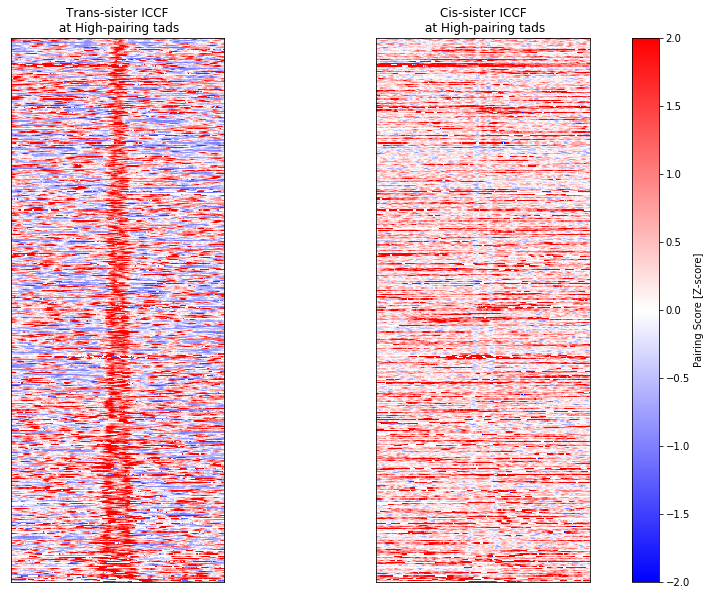

In [27]:
f, ax = plt.subplots(1, 2)
im = ax[0].imshow(normDictHigh["trans"], vmin=-2, vmax=2, cmap="bwr", aspect=1.5)
ax[1].imshow(normDictHigh["cis"], vmin=-2, vmax=2, cmap="bwr", aspect=1.5)
ax[0].set(title="Trans-sister ICCF\n at High-pairing tads")
ax[1].set(title="Cis-sister ICCF\n at High-pairing tads")
f.colorbar(im, ax=ax, label="Pairing Score [Z-score]")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

# Plot iccf not normalized to genome wide average

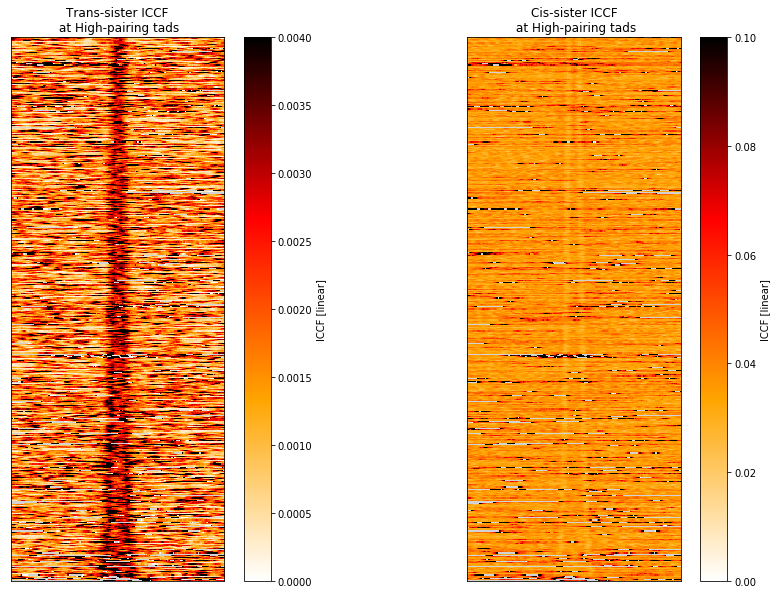

In [28]:
cmap = cl.LinearSegmentedColormap.from_list("fall", colors=["white", "orange" ,"red", "black"], N=256)
cmap.set_bad("lightgrey")


f, ax = plt.subplots(1, 2)
imT = ax[0].imshow(highResult["trans"], vmin=0, vmax=0.004, cmap=cmap, aspect=1.5, rasterized=True)
imC = ax[1].imshow(highResult["cis"], vmin=0, vmax=0.1, cmap=cmap, aspect=1.5, rasterized=True)
ax[0].set(title="Trans-sister ICCF\n at High-pairing tads")
ax[1].set(title="Cis-sister ICCF\n at High-pairing tads")
f.colorbar(imT, ax=ax[0], label="ICCF [linear]")
f.colorbar(imC, ax=ax[1], label="ICCF [linear]")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

In [50]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results/Nipbl"
f.savefig(os.path.join(resultsdir, "High_pairing_domains_line_profiles_WT_ICCF.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "High_pairing_domains_line_profiles_WT_ICCF.pdf"), bbox_inches="tight")

## Low TADs

In [29]:
low1dICCF = {}
for rType in ["cis", "trans"]:
    tempPile = pileupIndICCFLow[rType]
    tempList = []
    for boundaryIndex in range(tempPile.shape[2]):
        if boundaryIndex % 1000 == 0:
            print(boundaryIndex)
        indPile = tempPile[:, :, boundaryIndex]
        # blank out diagonal
        indPile[np.diag_indices_from(indPile)] = np.nan
        xVals, yVals = slidingDiamond(indPile, sideLen=10)
        tempFrame = pd.DataFrame({"xVals": xVals, "yVals": yVals, "ID": boundaryIndex})
        tempList.append(tempFrame)
    low1dICCF[rType] = pd.concat(tempList)

0
0


In [30]:
regionsLow.loc[:, "ID"] = range(len(regionsLow))
sortedSizeLow = regionsLow.sort_values(by="size", ascending=True)["ID"]
lowResult = {}
for rType in ["cis", "trans"]:
    temp = low1dICCF[rType]
    # expand into heatmap
    tempExp = pd.pivot_table(temp, columns="xVals", index="ID", values="yVals", dropna=False)
    # sort by size
    tempExp = tempExp.loc[sortedSizeLow,:].dropna(axis=0, how="all")
    lowResult[rType] = tempExp

In [31]:
normDictLow = {}
for rType in ["cis", "trans"]:
    temp = lowResult[rType]
    temp = temp - np.nanmedian(genomeWidePairing[rType])
    temp = temp/np.nanstd(genomeWidePairing[rType])
    normDictLow[rType] = temp

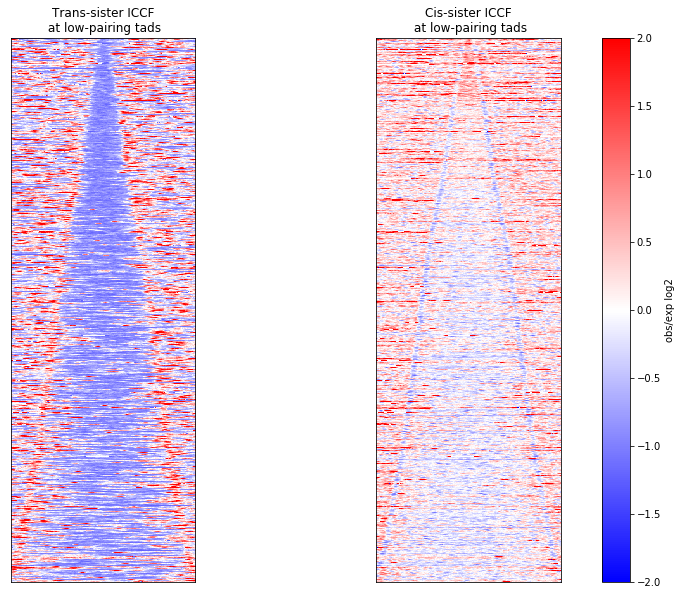

In [32]:
f, ax = plt.subplots(1, 2)
im = ax[0].imshow(normDictLow["trans"], vmin=-2, vmax=2, cmap="bwr", aspect=1.5)
ax[1].imshow(normDictLow["cis"], vmin=-2, vmax=2, cmap="bwr", aspect=1.5)
ax[0].set(title="Trans-sister ICCF\n at low-pairing tads")
ax[1].set(title="Cis-sister ICCF\n at low-pairing tads")
f.colorbar(im, ax=ax, label="obs/exp log2")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

# Plot ICCF

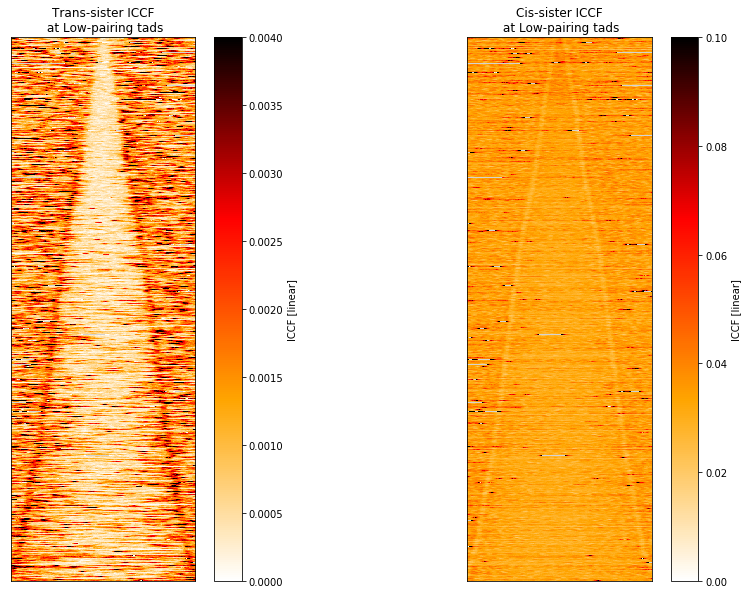

In [33]:
cmap = cl.LinearSegmentedColormap.from_list("fall", colors=["white", "orange" ,"red", "black"], N=256)
cmap.set_bad("lightgrey")


f, ax = plt.subplots(1, 2)
imT = ax[0].imshow(lowResult["trans"], vmin=0, vmax=0.004, cmap=cmap, aspect=1.5, rasterized=True)
imC = ax[1].imshow(lowResult["cis"], vmin=0, vmax=0.1, cmap=cmap, aspect=1.5, rasterized=True)
ax[0].set(title="Trans-sister ICCF\n at Low-pairing tads")
ax[1].set(title="Cis-sister ICCF\n at Low-pairing tads")
f.colorbar(imT, ax=ax[0], label="ICCF [linear]")
f.colorbar(imC, ax=ax[1], label="ICCF [linear]")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

In [52]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results/Nipbl"
f.savefig(os.path.join(resultsdir, "Low_pairing_domains_line_profiles_WT_ICCF.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "Low_pairing_domains_line_profiles_WT_ICCF.pdf"), bbox_inches="tight")

# Plot 1d lineprofile plot of high and bottom TADs (Nipbl)

## Coolers at 20kb binsize

In [34]:
HICPATHNipbl = "/groups/gerlich/experiments/Experiments_004800/004869/Sequencing_data/Pooled/cooler/"

BINSIZE = 20000
BARCODE = "G2.Nipbl-AID.wAuxin"
clrsNipbl = {interType:
        cooler.Cooler(
            os.path.join(HICPATHNipbl, f'{BARCODE}.{interType}.1000.mcool::/resolutions/{BINSIZE}'))
        for interType in ["cis", "trans"]}

## Get genome wide distribution of pairing score

In [35]:
genomeWidePairingScoreNipbl = getPairingScore(clrsNipbl["trans"], windowsize=10*10**4, norm=False, blankDiag=True)["PairingScore"]
genomeWidePairingScoreCisNipbl = getPairingScore(clrsNipbl["cis"], windowsize=10*10**4, norm=False, blankDiag=True)["PairingScore"]

In [36]:
genomeWidePairingNipbl = {}
genomeWidePairingNipbl["cis"] = genomeWidePairingScoreCisNipbl
genomeWidePairingNipbl["trans"] = genomeWidePairingScoreNipbl

## Extract individual windows

In [37]:
pileupIndICCFHighNipbl = {interType: HT.doPileupICCF(clrsNipbl[interType], windowsHigh, collapse=False)
                          for interType in ["cis", "trans"]}

In [38]:
pileupIndICCFLowNipbl = {interType: HT.doPileupICCF(clrsNipbl[interType], windowsLow, collapse=False)
                 for interType in ["cis", "trans"]}

## High TADs sliding diamond along windows

In [39]:
high1dICCFNipbl = {}
for rType in ["cis", "trans"]:
    tempPile = pileupIndICCFHighNipbl[rType]
    tempList = []
    for boundaryIndex in range(tempPile.shape[2]):
        if boundaryIndex % 1000 == 0:
            print(boundaryIndex)
        indPile = tempPile[:, :, boundaryIndex]
        # blank out diagonal
        indPile[np.diag_indices_from(indPile)] = np.nan
        xVals, yVals = slidingDiamond(indPile, sideLen=10)
        tempFrame = pd.DataFrame({"xVals": xVals, "yVals": yVals, "ID": boundaryIndex})
        tempList.append(tempFrame)
    high1dICCFNipbl[rType] = pd.concat(tempList)

0
0


## Prepare profiles for plotting

In [40]:
highResultNipbl = {}
for rType in ["cis", "trans"]:
    temp = high1dICCFNipbl[rType]
    # expand into heatmap
    tempExp = pd.pivot_table(temp, columns="xVals", index="ID", values="yVals", dropna=False)
    # sort by size
    tempExp = tempExp.loc[sortedSizeHigh,:].dropna(axis=0, how="all")
    highResultNipbl[rType] = tempExp

In [41]:
normDictHighNipbl = {}
for rType in ["cis", "trans"]:
    temp = highResultNipbl[rType]
    temp = temp - np.nanmedian(genomeWidePairingNipbl[rType])
    temp = temp/np.nanstd(genomeWidePairingNipbl[rType])
    normDictHighNipbl[rType] = temp

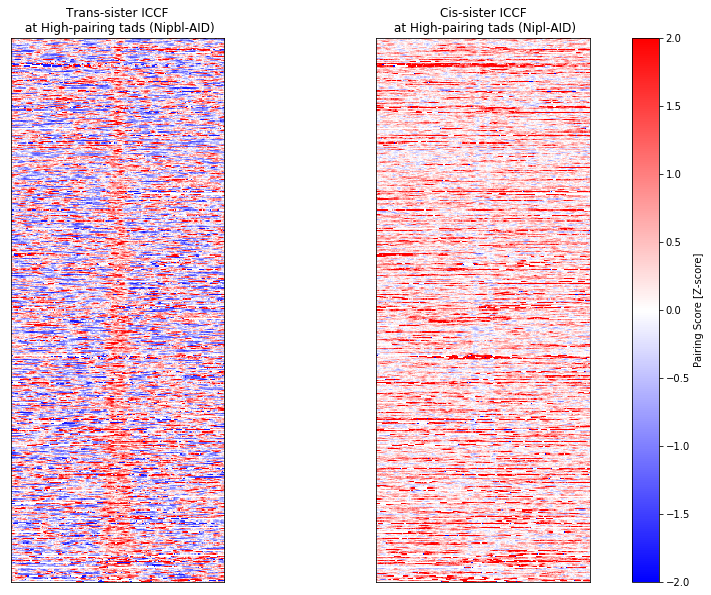

In [42]:
f, ax = plt.subplots(1, 2)
im = ax[0].imshow(normDictHighNipbl["trans"], vmin=-2, vmax=2, cmap="bwr", aspect=1.5)
ax[1].imshow(normDictHighNipbl["cis"], vmin=-2, vmax=2, cmap="bwr", aspect=1.5)
ax[0].set(title="Trans-sister ICCF\n at High-pairing tads (Nipbl-AID)")
ax[1].set(title="Cis-sister ICCF\n at High-pairing tads (Nipl-AID)")
f.colorbar(im, ax=ax, label="Pairing Score [Z-score]")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

In [50]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results/Nipbl"
f.savefig(os.path.join(resultsdir, "High_pairing_domains_line_profiles_Nipbl-AID.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "High_pairing_domains_line_profiles_Nipbl-AID.pdf"), bbox_inches="tight")

# Plot ICCF

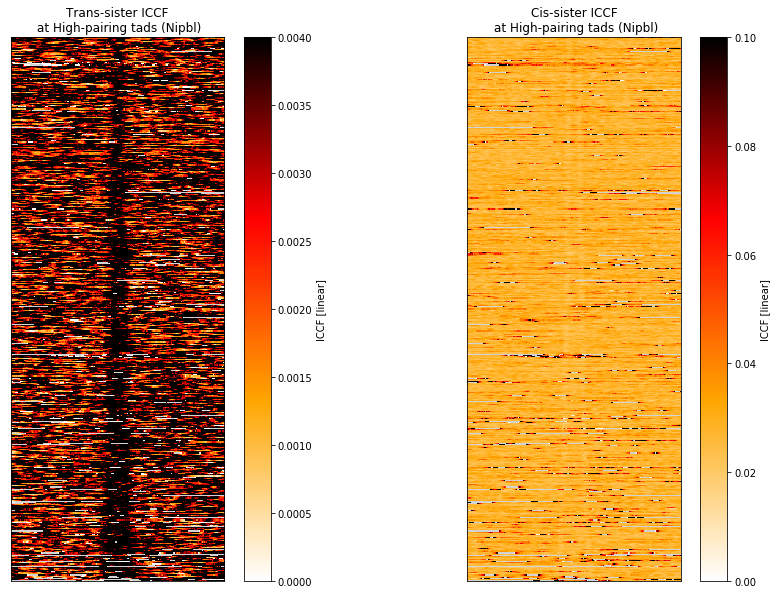

In [43]:
cmap = cl.LinearSegmentedColormap.from_list("fall", colors=["white", "orange" ,"red", "black"], N=256)
cmap.set_bad("lightgrey")


f, ax = plt.subplots(1, 2)
imT = ax[0].imshow(highResultNipbl["trans"], vmin=0, vmax=0.004, cmap=cmap, aspect=1.5, rasterized=True)
imC = ax[1].imshow(highResultNipbl["cis"], vmin=0, vmax=0.1, cmap=cmap, aspect=1.5, rasterized=True)
ax[0].set(title="Trans-sister ICCF\n at High-pairing tads (Nipbl)")
ax[1].set(title="Cis-sister ICCF\n at High-pairing tads (Nipbl)")
f.colorbar(imT, ax=ax[0], label="ICCF [linear]")
f.colorbar(imC, ax=ax[1], label="ICCF [linear]")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

In [54]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results/Nipbl"
f.savefig(os.path.join(resultsdir, "High_pairing_domains_line_profiles_Nipbl_ICCF.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "High_pairing_domains_line_profiles_Nipbl_ICCF.pdf"), bbox_inches="tight")

## Low pairing TADs

In [44]:
low1dICCFNipbl = {}
for rType in ["cis", "trans"]:
    tempPile = pileupIndICCFLowNipbl[rType]
    tempList = []
    for boundaryIndex in range(tempPile.shape[2]):
        if boundaryIndex % 1000 == 0:
            print(boundaryIndex)
        indPile = tempPile[:, :, boundaryIndex]
        # blank out diagonal
        indPile[np.diag_indices_from(indPile)] = np.nan
        xVals, yVals = slidingDiamond(indPile, sideLen=10)
        tempFrame = pd.DataFrame({"xVals": xVals, "yVals": yVals, "ID": boundaryIndex})
        tempList.append(tempFrame)
    low1dICCFNipbl[rType] = pd.concat(tempList)

0
0


In [45]:
lowResultNipbl = {}
for rType in ["cis", "trans"]:
    temp = low1dICCFNipbl[rType]
    # expand into heatmap
    tempExp = pd.pivot_table(temp, columns="xVals", index="ID", values="yVals", dropna=False)
    # sort by size
    tempExp = tempExp.loc[sortedSizeLow,:].dropna(axis=0, how="all")
    lowResultNipbl[rType] = tempExp

In [46]:
normDictLowNipbl = {}
for rType in ["cis", "trans"]:
    temp = lowResultNipbl[rType]
    temp = temp - np.nanmedian(genomeWidePairingNipbl[rType])
    temp = temp/np.nanstd(genomeWidePairingNipbl[rType])
    normDictLowNipbl[rType] = temp

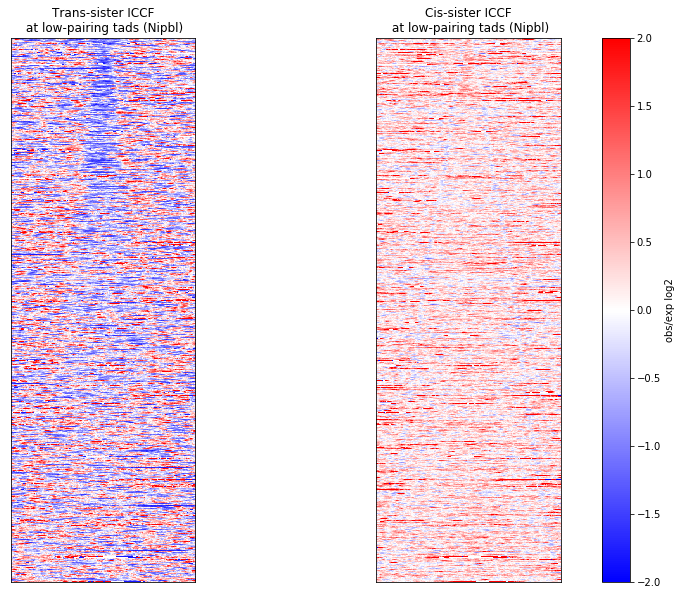

In [47]:
f, ax = plt.subplots(1, 2)
im = ax[0].imshow(normDictLowNipbl["trans"], vmin=-2, vmax=2, cmap="bwr", aspect=1.5)
ax[1].imshow(normDictLowNipbl["cis"], vmin=-2, vmax=2, cmap="bwr", aspect=1.5)
ax[0].set(title="Trans-sister ICCF\n at low-pairing tads (Nipbl)")
ax[1].set(title="Cis-sister ICCF\n at low-pairing tads (Nipbl)")
f.colorbar(im, ax=ax, label="obs/exp log2")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

In [54]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results/Nipbl"
f.savefig(os.path.join(resultsdir, "Low_pairing_domains_line_profiles_Nipbl-AID.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "Low_pairing_domains_line_profiles_Nipbl-AID.pdf"), bbox_inches="tight")

# Plot ICCF

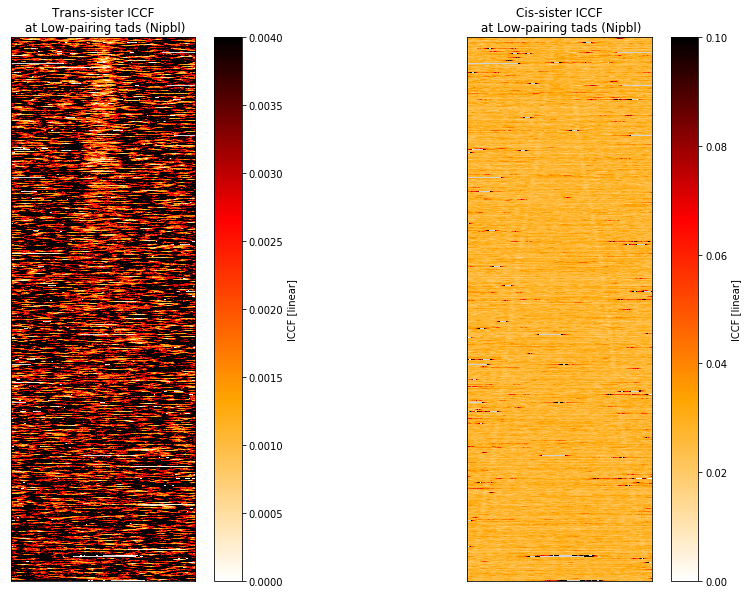

In [48]:
cmap = cl.LinearSegmentedColormap.from_list("fall", colors=["white", "orange" ,"red", "black"], N=256)
cmap.set_bad("lightgrey")


f, ax = plt.subplots(1, 2)
imT = ax[0].imshow(lowResultNipbl["trans"], vmin=0, vmax=0.004, cmap=cmap, aspect=1.5, rasterized=True)
imC = ax[1].imshow(lowResultNipbl["cis"], vmin=0, vmax=0.1, cmap=cmap, aspect=1.5, rasterized=True)
ax[0].set(title="Trans-sister ICCF\n at Low-pairing tads (Nipbl)")
ax[1].set(title="Cis-sister ICCF\n at Low-pairing tads (Nipbl)")
f.colorbar(imT, ax=ax[0], label="ICCF [linear]")
f.colorbar(imC, ax=ax[1], label="ICCF [linear]")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

In [62]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results/Nipbl"
f.savefig(os.path.join(resultsdir, "Low_pairing_domains_line_profiles_Nipbl_ICCF.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "Low_pairing_domains_line_profiles_Nipbl_ICCF.pdf"), bbox_inches="tight")